# Converting Codes into Amps and Volts using optimization

## Data Ingestion

### Get from DataLogger

In [1117]:
from datetime import timedelta, datetime
import pandas as pd
datalogger = pd.read_csv("data/230604-174212.csv")

datalogger.rename(columns={
    "CH6": "voltage",
    "CH5": "current"
}, inplace=True)

dataloggerTimestamps = [(datetime.strptime(d, '%Y-%m-%d %H:%M:%S')) for d in datalogger['Date&Time']]
dataloggerCurrents = [d * -1 for d in datalogger['current']]

datalogger.head()

,No.,Date&Time,ms,current,voltage,Pulse1,Alarm1,AlarmLP,AlarmOut
0,1,2023-06-04 17:42:12,0,-0.032,52.76,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
1,2,2023-06-04 17:42:12,50,-0.040,52.76,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
2,3,2023-06-04 17:42:12,100,-0.032,52.76,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
3,4,2023-06-04 17:42:12,150,-0.040,52.76,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
4,5,2023-06-04 17:42:12,200,-0.040,52.76,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL


### Get from AWS

In [1118]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [1119]:
import pandas as pd

data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('esp32-codes-check1')
)['Items']

failed = 0
parsed_data = []
for row in data:
    try:
        
        messages = row['messages'].split('|')
        i = 0
        for message in messages:
            split = message.split(',')
            
            try:
                parsed_data.append(
                    {
                        'aws_timestamp': row['timestamp'],
                        'test_id': row['test_id'],
                        'timestamp': datetime.strptime(row['timestamp'], '%Y-%m-%d %H:%M:%S.%f') - timedelta(milliseconds=100 * (len(messages) - i)),
                        'throttle': int(split[1]),
                        'speed': int(split[2]),
                        'rpm': int(split[3]),
                        'current': int(split[4]),
                        'voltage': int(split[5]),
                        'throttleTooHigh': int(split[6]),
                        'motorInitializing': int(split[7]),
                        'clockState': int(split[8]),
                        'lastDeadman': split[9]
                    }
                )
            except:
                # print(f"Failed to parse message chunk: {split}")
                failed += 1
        
            i += 1
    except:
        print(f"Failed to parse {row['test_id']} message with timestamp: {row['timestamp']}.")


telemetry_data = pd.DataFrame(parsed_data)
print(f"Failed to parse {failed} out of {telemetry_data.size + failed} messages")
telemetry_data.head(8000)

Failed to parse 4 out of 50956 messages


,aws_timestamp,test_id,timestamp,throttle,speed,rpm,current,voltage,throttleTooHigh,motorInitializing,clockState,lastDeadman
0,2023-06-04 20:33:47.538,esp32-codes-check1,2023-06-04 20:33:42.538,0,0,0,0,3497,0,1,0,00.02.58
1,2023-06-04 20:33:47.538,esp32-codes-check1,2023-06-04 20:33:42.638,0,0,0,0,3499,0,1,0,00.02.58
2,2023-06-04 20:33:47.538,esp32-codes-check1,2023-06-04 20:33:42.738,0,0,0,0,3508,0,1,0,00.02.58
3,2023-06-04 20:33:47.538,esp32-codes-check1,2023-06-04 20:33:42.838,0,0,0,0,3504,0,1,0,00.02.58
4,2023-06-04 20:33:47.538,esp32-codes-check1,2023-06-04 20:33:42.938,0,0,0,0,3500,0,1,0,00.02.58
...,...,...,...,...,...,...,...,...,...,...,...,...
4241,2023-06-04 21:25:16.250,esp32-codes-check1,2023-06-04 21:25:15.750,0,0,0,286,3491,0,0,0,00.00.00
4242,2023-06-04 21:25:16.250,esp32-codes-check1,2023-06-04 21:25:15.850,0,0,0,671,3472,0,0,0,00.00.00
4243,2023-06-04 21:25:16.250,esp32-codes-check1,2023-06-04 21:25:15.950,0,0,0,8,3537,0,0,0,00.00.00
4244,2023-06-04 21:25:16.250,esp32-codes-check1,2023-06-04 21:25:16.050,0,0,0,0,3539,0,0,0,00.00.00


In [1120]:
telemetry_i = telemetry_data.current.argmax()
datalogger_i = datalogger.current.argmax()

time_difference = parsed_data[telemetry_i]['timestamp'] - dataloggerTimestamps[datalogger_i]

dataloggerTimestamps = [timestamp + time_difference + timedelta(seconds=6) for timestamp in dataloggerTimestamps]

print(telemetry_i, datalogger_i, "Difference:", time_difference)

1502 1130 Difference: 2:51:50.749000


In [1121]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime, timedelta

def codeToVoltage(x):
    return 0.02048 * x + -0.53823 + 0.5

def codeToAmps(x):
    return 0.00013 * x + 0.57164

processed: List[TelemetryDataPoint] = []
for i, row in telemetry_data.iterrows():
    try:
        d = TelemetryDataPoint(
                timestamp=parsed_data[i]['timestamp'],
                speed=float(row['speed']) / 1000, # m/h -> km/h
                voltage=codeToVoltage(row['voltage']),
                current=codeToAmps(row['current']),
                rpm=int(row['rpm']) * -1
            )
        
        processed.append(
            d
        )        
    except Exception as e:
        print(f"Failed to convert point: {i}, {e}")
        telemetry_data.drop(i)

currentCodes = telemetry_data.current.tolist()
voltageCodes = telemetry_data.voltage.tolist()

In [1122]:
instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)
instantEfficiencyDataPoints[:5 if len(instantEfficiencyDataPoints) > 5 else -1]

[InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 6, 4, 20, 33, 43, 38000), instant_efficiency=0.0),
 InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 6, 4, 20, 33, 44, 38000), instant_efficiency=-0.0),
 InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 6, 4, 20, 33, 45, 38000), instant_efficiency=-0.0),
 InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 6, 4, 20, 33, 46, 38000), instant_efficiency=0.0),
 InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 6, 4, 20, 33, 47, 38000), instant_efficiency=0.0)]

### Processing Data

## Graphing Data

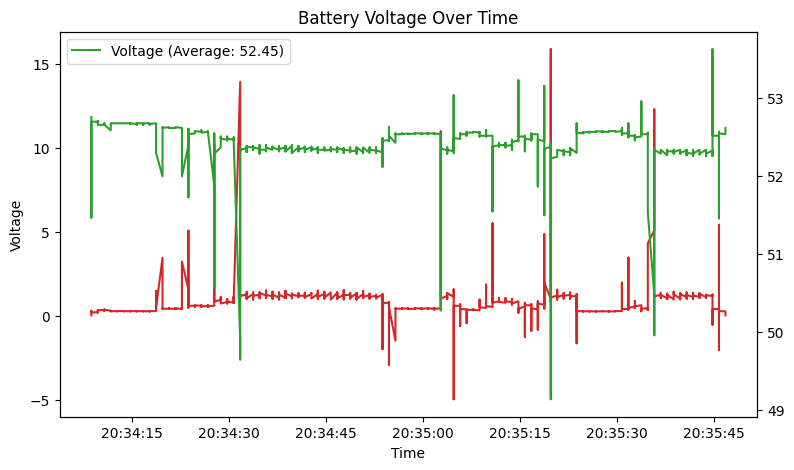

In [1123]:
import matplotlib.pyplot as plt
timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
voltages = [point.voltage for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, ax = plt.subplots()
fig.set_size_inches(9,5)

# ax.set_ylim(40, 56)

ax.set_title("Battery Voltage Over Time")
ax.set_ylabel("Voltage")
ax.set_xlabel("Time")

ax.plot(dataloggerTimestamps, dataloggerCurrents, label="Current", color='tab:red')

ax1 = ax.twinx()

ax1.plot(dataloggerTimestamps, datalogger.get('voltage', []), color='tab:green')
legend = [
    'Voltage (Average: %.2f)' %(sum(datalogger.get('voltage', [])) / len(datalogger.get('voltage', [])) if len(datalogger.get('voltage', [])) > 0 else 1),
    # 'Datalogger Voltage (Average: %.2f)' %(sum(datalogger.get('voltage', [])) / len(datalogger.get('voltage', [])) if len(datalogger.get('voltage', [])) > 0 else 1)
    ]
ax1.legend(legend)

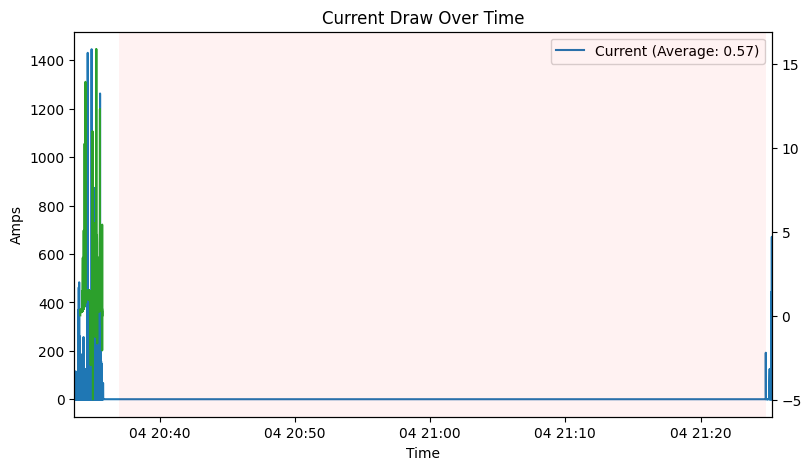

In [1124]:
import numpy as np
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("Current Draw Over Time")
ax.set_ylabel("Amps")
ax.set_xlabel("Time")

timeDiffs = np.diff(timestamps)
missingGaps = timeDiffs > timedelta(microseconds=100000)

minTime = timestamps[0] if timestamps[0] < dataloggerTimestamps[0] else dataloggerTimestamps[0]
maxTime = timestamps[-1] if timestamps[-1] > dataloggerTimestamps[-1] else dataloggerTimestamps[-1]

ax.set_xlim(minTime, maxTime)

ax.plot(timestamps, currentCodes)

ax1 = ax.twinx()
ax1.set_xlim(minTime, maxTime)

ax1.plot(dataloggerTimestamps, dataloggerCurrents, color='tab:green')

# Iterate over the large gaps and color the background red for each gap
for i, gap in enumerate(missingGaps):
    if gap:
        plt.axvspan(timestamps[i], timestamps[i+1], facecolor='red', alpha=0.05)

legend = ['Current (Average: %.2f)' %(sum(currents) / len(currents)), 'Datalogger Current (Average: %.2f)' %(sum(dataloggerCurrents) / len(dataloggerCurrents))]

ax.legend(legend)

1446


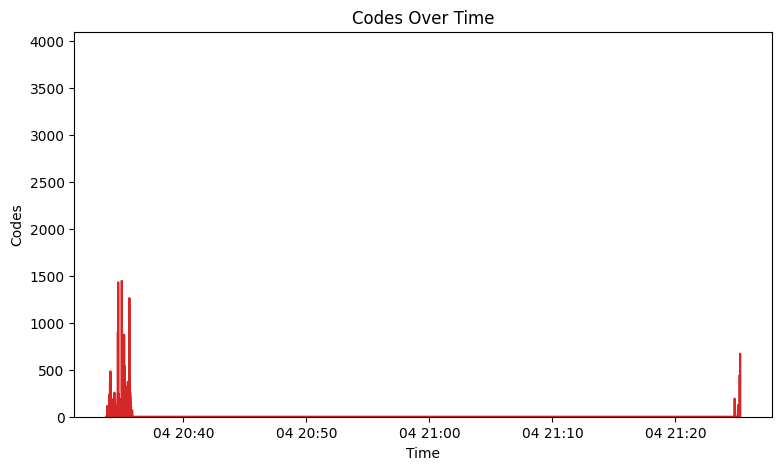

In [1125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(9,5)

# ax.set_ylim(40, 56)

ax.set_title("Codes Over Time")
ax.set_ylabel("Codes")
ax.set_xlabel("Time")

ax.set_ylim(0, 4096)

ax.plot(timestamps, currentCodes, label="Current", color='tab:red')

# ax1 = ax.twinx()
# ax1.plot(timestamps, currents)
print(max(currentCodes))

# ax1 = ax.twinx()

# ax1.plot(dataloggerTimestamps, datalogger.get('voltage', []), color='tab:green')
# legend = [
#     'Voltage (Average: %.2f)' %(sum(datalogger.get('voltage', [])) / len(datalogger.get('voltage', [])) if len(datalogger.get('voltage', [])) > 0 else 1),
#     # 'Datalogger Voltage (Average: %.2f)' %(sum(datalogger.get('voltage', [])) / len(datalogger.get('voltage', [])) if len(datalogger.get('voltage', [])) > 0 else 1)
#     ]
# ax1.legend(legend)

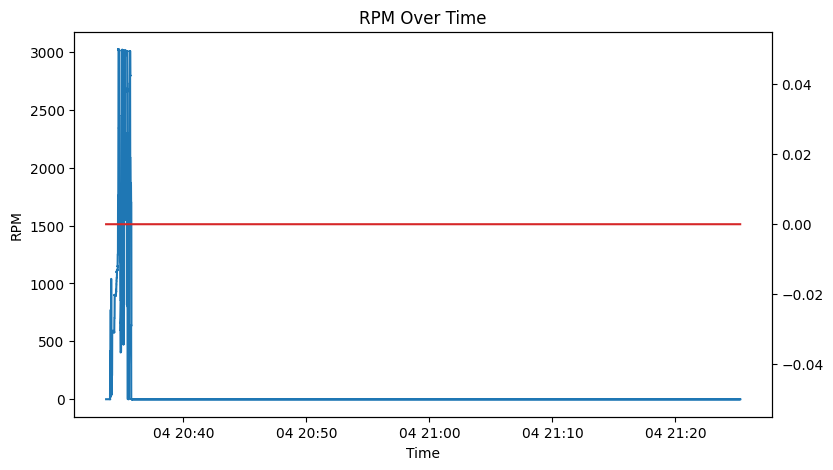

In [1126]:
import numpy as np
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("RPM Over Time")
ax.set_ylabel("RPM")
ax.set_xlabel("Time")
ax.plot(timestamps, rpms)
ax1 = ax.twinx()
ax1.plot(timestamps, speeds, color='tab:red')

# Interpolating data

In [1127]:
import numpy as np
from scipy.interpolate import interp1d

overlap_start = 0
overlap_end = 0

while overlap_start < len(timestamps) - 1 and timestamps[overlap_start] < dataloggerTimestamps[0]:
    overlap_start += 1
        
while overlap_end < len(timestamps) - 1 and timestamps[overlap_end] < dataloggerTimestamps[-1]:
    overlap_end += 1

overlapTimestamps = timestamps[overlap_start:overlap_end]
overlapCodes = currentCodes[overlap_start:overlap_end]

# Create interpolation function for datalogger data.
# t.timestamp() gets integer value for interpolation calculations.
f = interp1d([t.timestamp() for t in dataloggerTimestamps], dataloggerCurrents, kind='nearest')
interpolatedCurrents = [f(timestamp.timestamp()) for timestamp in overlapTimestamps]

ValueError: A value (1685925247.641) in x_new is below the interpolation range's minimum value (1685925248.749).

Current = 1.00000 * x + 0.59083


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


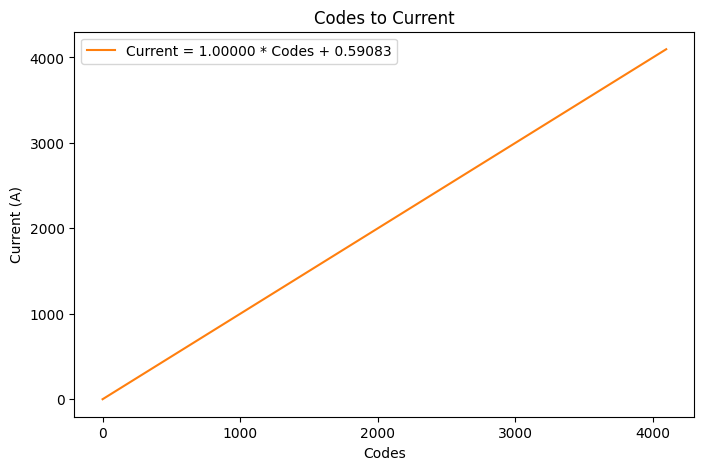

In [ ]:
# SciPy's optimize functions require data to be sampled at same time
# This can be mitigated by interpolating datapoints using numpy
import numpy as np
from scipy.optimize import curve_fit

def objective(x, a, b):
    '''Objective for curve fitting'''
    return a * x + b

popt, _ = curve_fit(objective, overlapCodes, interpolatedCurrents)
a, b = popt

fig, ax = plt.subplots()
fig.set_size_inches(8,5)

ax.set_title("Codes to Current")
ax.set_ylabel("Current (A)")
ax.set_xlabel("Codes")

x = np.linspace(0,4096,100)
y = a*x + b
ax.plot(x, y, color="tab:orange")

legend = ["Current = %.5f * Codes + %.5f" % (a, b)]
ax.legend(legend)
print("Current = %.5f * x + %.5f" % (a, b))

overlapCurrents = [a * code + b for code in overlapCodes]


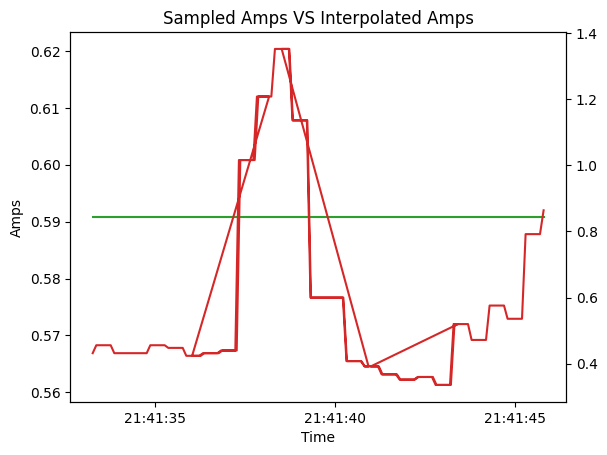

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Sampled Amps VS Interpolated Amps")
ax.set_xlabel("Time")
ax.set_ylabel("Amps")

ax.plot(overlapTimestamps, overlapCurrents, color="tab:green")
# ax.plot(dataloggerTimestamps, dataloggerCurrents, color="tab:blue")

ax1 = ax.twinx()
ax1.plot(overlapTimestamps, interpolatedCurrents, color="tab:red")

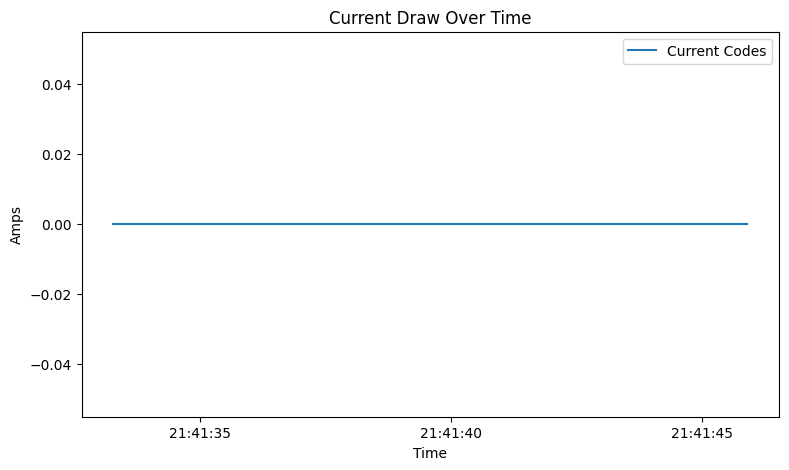

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("Current Draw Over Time")
ax.set_ylabel("Amps")
ax.set_xlabel("Time")

ax.plot(timestamps, currentCodes)

legend = ['Current Codes']

ax.legend(legend)

In [ ]:
(12.5*3.3/1)*(1/(6/4096))

28160.0

0.008056640625
Current = 0.00806 * x + 0.00000


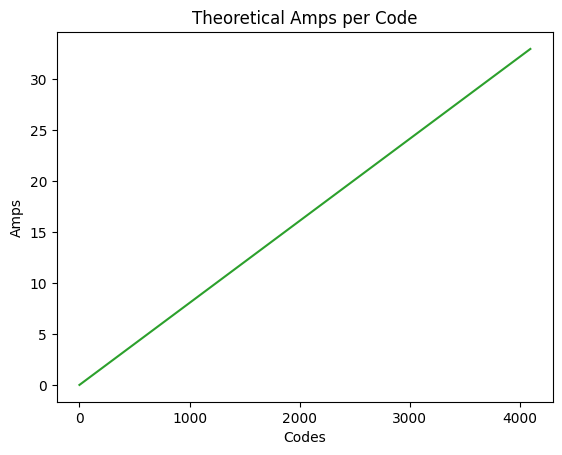

In [ ]:
import matplotlib.pyplot as plt
# V per Amp
vPerAmp = 0.0125

# V per Amp (Scaled)
vPerAmpScaled = vPerAmp * 8

# Codes per V
codesPerVolt = 4096 / 3.3

codesPerAmp = vPerAmpScaled * codesPerVolt

ampsPerCode = 1 / codesPerAmp

print(ampsPerCode)

fig, ax = plt.subplots()
ax.set_title("Theoretical Amps per Code")
ax.set_xlabel("Codes")
ax.set_ylabel("Amps")

codes = np.linspace(0, 4095, 100)
amps = ampsPerCode * codes

ax.plot(codes, amps, color="tab:green")

print("Current = %.5f * x + %.5f" % (ampsPerCode, 0))